In [3]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import truvari

In [19]:
data = pd.read_csv("similarity_500.txt", sep='\t')

[Text(0.5, 1.0, 'Sequence Similarity vs Canberra Similarity'),
 Text(0, 0.5, 'Canberra Sim.'),
 Text(0.5, 0, 'Seq. Sim.')]

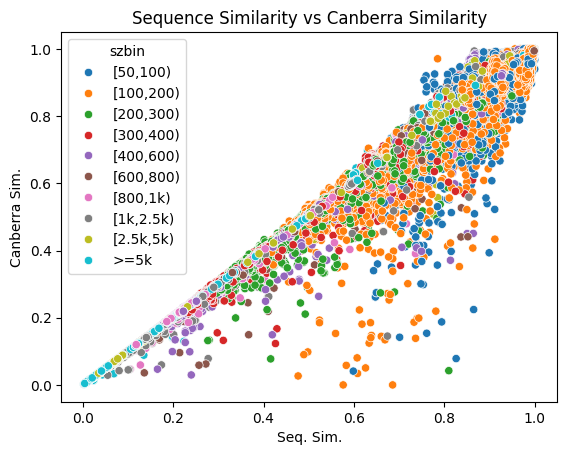

In [20]:
p = sb.scatterplot(data=data, x="seqsim", y="cansim", hue="szbin", hue_order=truvari.SZBINS[8:])
p.set(title="Sequence Similarity vs Canberra Similarity", ylabel="Canberra Sim.", xlabel="Seq. Sim.")

In [11]:
bigdiff = (data['cansim'] - data['seqsim']).abs() > .5

In [21]:
from scipy.stats import pearsonr
pearsonr(data['seqsim'], data['cansim'])

PearsonRResult(statistic=0.9948078926138118, pvalue=0.0)

In [22]:
len(data)

139374

In [23]:
print(pearsonr(data['seqsim'], data['szsim']))
print(pearsonr(data['szsim'], data['cansim']))

PearsonRResult(statistic=0.9834014357255881, pvalue=0.0)
PearsonRResult(statistic=0.9787727946616263, pvalue=0.0)


[Text(0.5, 1.0, 'Sequence Similarity vs Canberra Similarity'),
 Text(0, 0.5, 'Canberra Sim.'),
 Text(0.5, 0, 'Seq. Sim.')]

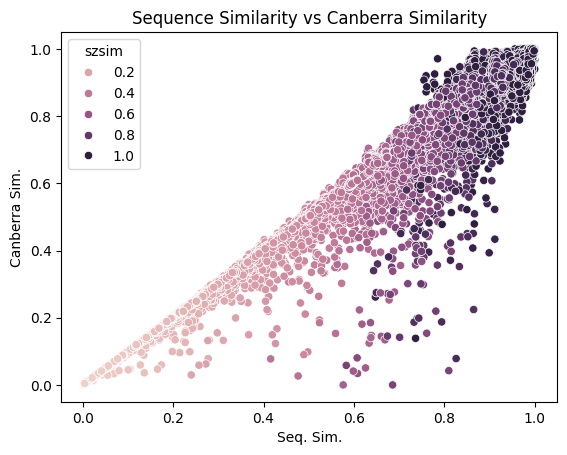

In [24]:
p = sb.scatterplot(data=data, x="seqsim", y="cansim", hue="szsim")#, hue_order=truvari.SZBINS[8:])
p.set(title="Sequence Similarity vs Canberra Similarity", ylabel="Canberra Sim.", xlabel="Seq. Sim.")